In [63]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.features import build_features

warnings.filterwarnings("ignore")

sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

# Objetivo del cuadernillo

En este cuadernillo se quieren incluir 3 secciones principales:

1. Análisis Exploratorio de los datos para los egresos hospitalarios del INT entre 2001 a 2019.
2. Entrenamiento de modelos predictivos
3. Estimación de Egresos Hospitalarios a 2035

In [65]:
# Lee la base de datos
egresos_torax = pd.read_csv("../data/processed/egresos_torax_mes_y_dia.csv")

# Crea columna de fecha en datetime
egresos_torax["FECHA_EGRESO"] = pd.to_datetime(
    egresos_torax["ANO_EGRESO"].astype(str)
    + "-"
    + egresos_torax["MES_EGRESO"].astype(str)
    + "-"
    + egresos_torax["DIA_EGRESO"].astype(str),
    format="%Y-%m-%d",
)

# Elimina columnas redundantes
egresos_torax = egresos_torax.drop(
    columns=[
        "ANO_EGRESO",
        "MES_EGRESO",
        "DIA_EGRESO",
        "ESTABLECIMIENTO_SALUD",
        "GLOSA_ESTABLECIMIENTO_SALUD",
    ]
).sort_values("FECHA_EGRESO")

# Elimina el anio 2020, debido a que es anomalo (Pandemia COVID)
egresos_torax = egresos_torax.query("FECHA_EGRESO < '2020-01-01'")

# Elige la fecha como indice de los datos
egresos_torax = egresos_torax.set_index("FECHA_EGRESO")

Ahora, se quiere hacer un análisis del INT completo y también para los 45 diagnósticos más relevantes para el Hospital.

In [66]:
DIAGS_MAS_RELEVANTES = [
    "C33X",
    "C340",
    "C341",
    "C342",
    "C343",
    "C381",
    "C384",
    "C450",
    "C780",
    "C782",
    "D143",
    "D381",
    "E848",
    "I080",
    "I081",
    "I340",
    "I350",
    "I351",
    "I352",
    "I420",
    "I456",
    "I472",
    "I495",
    "I710",
    "I712",
    "J398",
    "J47X",
    "J679",
    "J841",
    "J848",
    "J849",
    "J860",
    "J869",
    "J90X",
    "J91X",
    "J931",
    "J955",
    "J980",
    "M348",
    "Q211",
    "Q231",
    "Q676",
    "T820",
    "T821",
    "Z450",
]

In [67]:
# Obtiene metricas agregadas por dia (suma los egresos de todos los diags por dia)
df = egresos_torax.resample("D").sum()[["n_egresos"]]
df_relevantes = (
    egresos_torax[egresos_torax["DIAG1"].isin(DIAGS_MAS_RELEVANTES)]
    .resample("D")
    .sum()[["n_egresos"]]
)

## 1. Análisis Exploratorio de los Datos

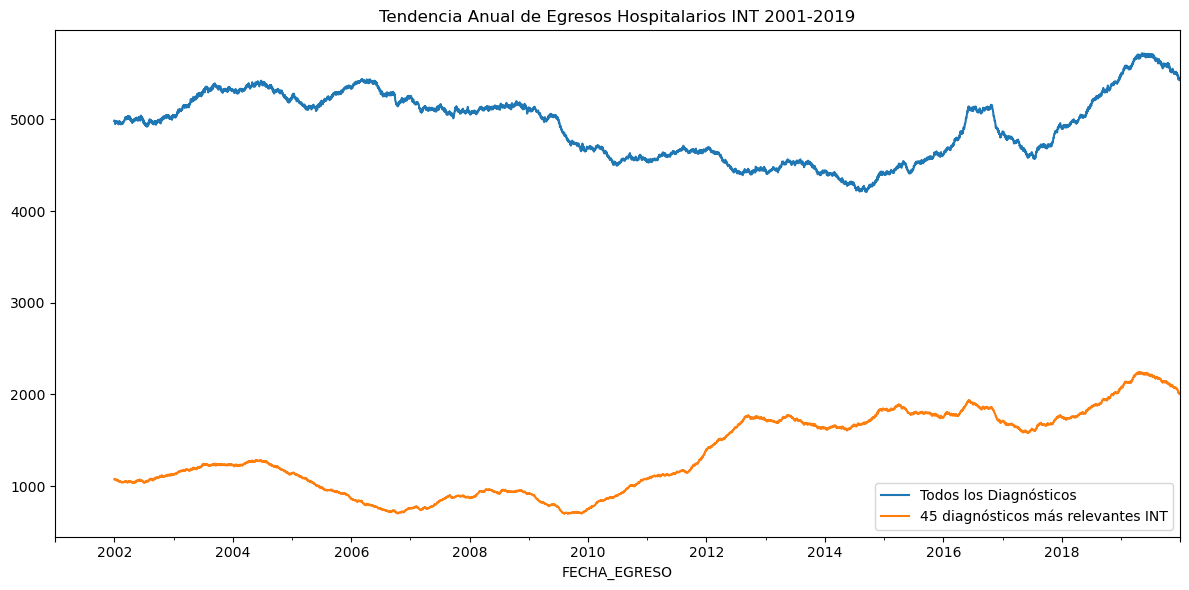

In [68]:
fig, axis = plt.subplots(1, 1, sharey=True)

ROLLING_AVERAGE = 365

df.rolling(ROLLING_AVERAGE).sum().plot(y="n_egresos", label="Todos los Diagnósticos", ax=axis)
df_relevantes.rolling(ROLLING_AVERAGE).sum().plot(
    y="n_egresos", label="45 diagnósticos más relevantes INT", ax=axis
)

plt.title("Tendencia Anual de Egresos Hospitalarios INT 2001-2019")
plt.tight_layout()
plt.legend()
plt.show()

Los resultados muestran lo siguiente:

- Los Egresos Totales del INT muestran un patrón ciclico. Desde el 2002 hasta el 2010 se vió un peak de egresos hospitalarios. Este peak disminuyó dede 2011 hasta 2016. Finalemnte, desde 2016 hasta 2019 se observó un nuevo peak en la cantidad de Egresos Hospitalarios.

- Los 45 diagnósticos más relevantes representan aproximadamente un 40% de los egresos hospitalarios totales (observando 2013 específicamente). Además, se observa una tendencia al aumento de estos egresos hospitalarios desde 2012 a 2019.

Notar que el aumento pronunciado de egresos entre 2010 a 2012 de los 45 diagnósticos más relevantes ocurrió debido al cambio de codificación desde la unidad de estadística a GRD en el INT.

## Análisis de variables temporales

In [69]:
# Agrega variables temporales
df_features_temporales = build_features.create_features_datetime_index(df)

# Convierte los datos a formato largo para ocupar FacetGrid en seaborn
melted = df_features_temporales.melt(id_vars=["n_egresos"])

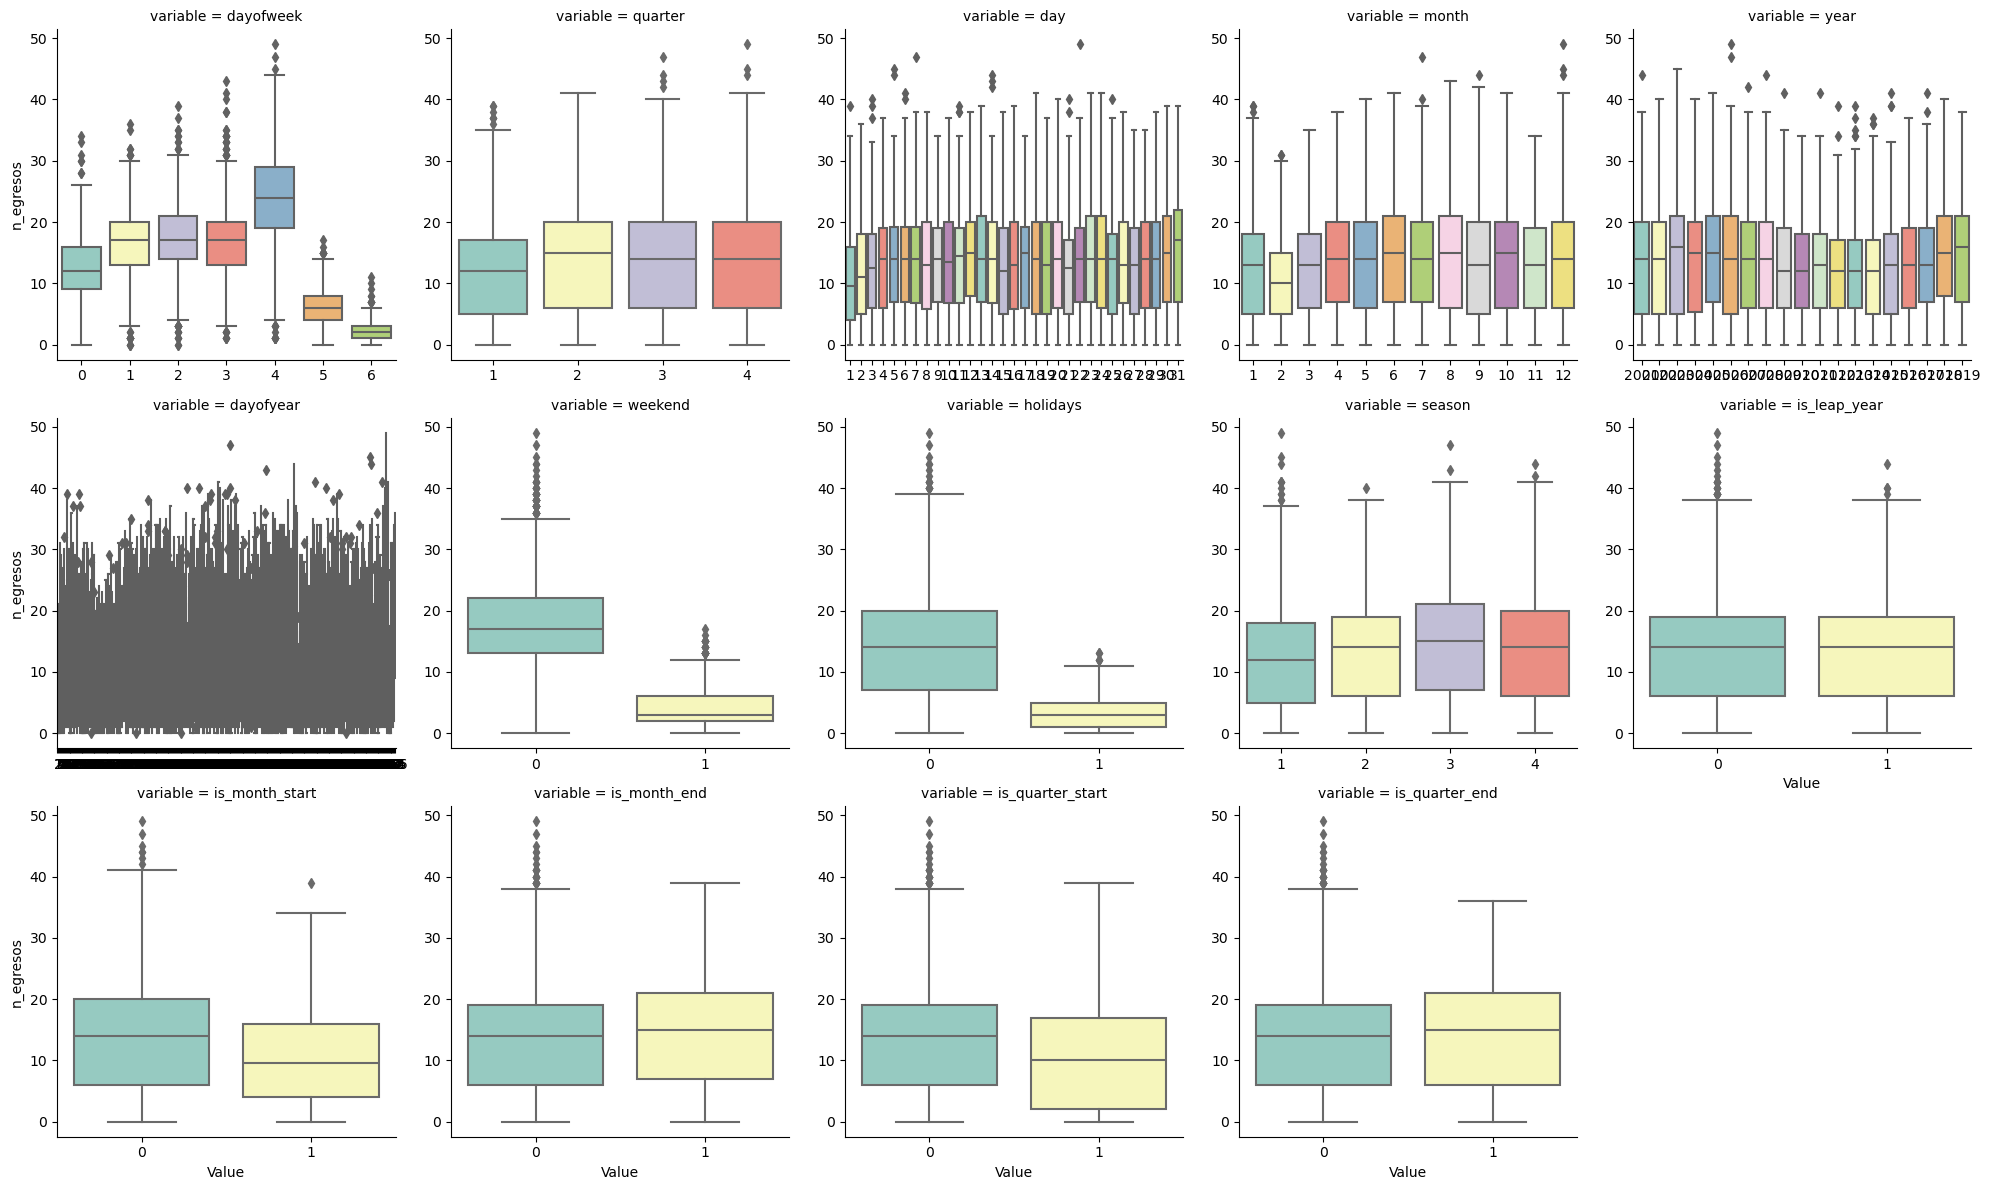

In [70]:
# Muestra el EDA
g = sns.FacetGrid(melted, col="variable", col_wrap=5, height=4, sharey=False, sharex=False)
g.map_dataframe(sns.boxplot, x="value", y="n_egresos", palette="Set3")
g.set_axis_labels("Value", "n_egresos")
plt.show()

Los resultados indican lo siguiente:

- La mayor cantidad de egresos hospitalarios ocurre en la semana, teniendo un peak los viernes (dayofweek = 5).

- Se observa una cantidad de egresos similares entre los trimestres. Sin embargo, se aprecia un pequeño descenso en los egresos en el primer trimestre.

- Dentro de un mes, la cantidad de egresos se mantiene similares en cada uno de los días. Sin embargo, es posible apreciar un leve aumento en el día 30 y 31 de un mes.

- Los egresos hospitalarios son similares entre los meses del año. Sin embargo, en febrero se puede ver un descenso en la cantidad de egresos.

- A lo largo de los años se observa una tendencia al aumento de egresos hospitalarios.

- EL gráfico de días del año es difícil de interpretar.

- Hay una mayor cantidad de egresos en la semana que en los fin de semanas.

- Hay una menor cantidad de egresos cuando el día es feriado.

- Se aprecia una cantidad de egresos similar entre estaciones del año. Sin embargo, pareciera que en la temporada 1 hay un descenso en egresos, mientras que en la temporada 3 hay un aumento.

- Un año bisiesto tiene la misma cantidad de egresos que un año no bisiesto.

- Al inicio de los meses se ve un descenso de egresos

- Existe una cantidad de egresos similar entre el fin de mes que con todo el mes.

- Existe una menor cantidad de egresos al inicio del trimestre

- Existe una cantidad similar de egresos al termino de un trimestre y todo el trimestre.